<a href="https://colab.research.google.com/github/Nisha40108/ADVANCED-MACHINE-LEARNING-64061-/blob/main/Assignment_4_Text%26Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 4 - Text and Sequence Data using IMDB dataset**

# **Name: Nisha Chaurasia**

# **Date: 11-26-2023**

In [48]:
!pip install tensorflow==2.12

**Loading the important libraries**

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').disabled = True

**Importing TensorFlow and Keras:**

In [50]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import load_model
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from google.colab import files
import re, os

#### Considering the IMDB example from Chapter 6. Re-running the example and modifying the  by **implementing a cutoff for reviews after 150 words, Training Sample - 100, Validation Sample - 10000, Consider only the top 10,000 words**

### **Model 1: Basic model from scratch**

In [134]:
num_words = 10000
maxlen = 150

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)


# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=100, test_size=10000, random_state=42, stratify=labels)
print(train_texts.shape)
# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

# Create a tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_texts)

# Convert text sequences to numerical sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to have consistent length
train_data_vectorized = pad_sequences(train_sequences, maxlen=max_len)
val_data_vectorized = pad_sequences(val_sequences, maxlen=max_len)
test_data_vectorized = pad_sequences(test_sequences, maxlen=max_len)

(100, 150)


AttributeError: ignored

In [111]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  1236k      0  0:01:06  0:01:06 --:--:-- 1101k


In [130]:
import os
import pathlib
import shutil
import random
from tensorflow import keras

batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

# Check if the destination directory exists before creating it
for category in ("neg", "pos"):
    val_category_dir = val_dir / category
    if not os.path.exists(val_category_dir):
        os.makedirs(val_category_dir)

        files = os.listdir(train_dir / category)
        random.Random(1337).shuffle(files)
        num_val_samples = int(0.2 * len(files))
        val_files = files[-num_val_samples:]

        for fname in val_files:
            shutil.move(train_dir / category / fname, val_category_dir / fname)

In [139]:
import os
import pathlib
import shutil
import random
from tensorflow import keras

batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

# Check if the destination directory exists before creating it
for category in ("neg", "pos"):
    val_category_dir = val_dir / category
    if not os.path.exists(val_category_dir):
        os.makedirs(val_category_dir)

        files = os.listdir(train_dir / category)
        random.Random(1337).shuffle(files)
        num_val_samples = int(0.2 * len(files))
        val_files = files[-num_val_samples:]

        for fname in val_files:
            shutil.move(train_dir / category / fname, val_category_dir / fname)

# Rest of your code remains the same
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = combined_ds.map(lambda x, y: x)

Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [145]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
combined_ds = int_train_ds.concatenate(int_val_ds).concatenate(int_test_ds)

# Shuffle the combined dataset
shuffled_ds = combined_ds.shuffle(buffer_size=len(combined_ds), seed=42)

# Define sizes for each split
train_size = 100
val_size = 10000
test_size = 5000

# Split the shuffled dataset
train_ds = shuffled_ds.take(train_size)
val_ds = shuffled_ds.skip(train_size).take(val_size)
test_ds = shuffled_ds.skip(train_size + val_size).take(test_size)

In [149]:
print(train_ds)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 600), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [53]:
val_texts.shape

(10000, 150)

In [54]:
test_texts.shape

(5000, 150)

**Model Building**

In [55]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_5 (Flatten)         (None, 1200)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


**Model Execution**

In [56]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model1.h5",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_1 = model.fit(train_ds, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
4/4 [==============================] - 2s 331ms/step - loss: 0.6898 - accuracy: 0.5600 - val_loss: 0.6933 - val_accuracy: 0.5006
Epoch 2/30
4/4 [==============================] - 1s 281ms/step - loss: 0.6679 - accuracy: 0.8900 - val_loss: 0.6932 - val_accuracy: 0.5021
Epoch 3/30
4/4 [==============================] - 1s 271ms/step - loss: 0.6525 - accuracy: 0.9600 - val_loss: 0.6932 - val_accuracy: 0.5040
Epoch 4/30
4/4 [==============================] - 1s 292ms/step - loss: 0.6388 - accuracy: 0.9900 - val_loss: 0.6931 - val_accuracy: 0.5067
Epoch 5/30
4/4 [==============================] - 1s 313ms/step - loss: 0.6261 - accuracy: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.5084
Epoch 6/30
4/4 [==============================] - 1s 328ms/step - loss: 0.6130 - accuracy: 1.0000 - val_loss: 0.6932 - val_accuracy: 0.5069
Epoch 7/30
4/4 [==============================] - 1s 318ms/step - loss: 0.5997 - accuracy: 1.0000 - val_loss: 0.6932 - val_accuracy: 0.5080
Epoch 8/30
4/4 [====

**Ploating the Accuracy and loss for training and validation**

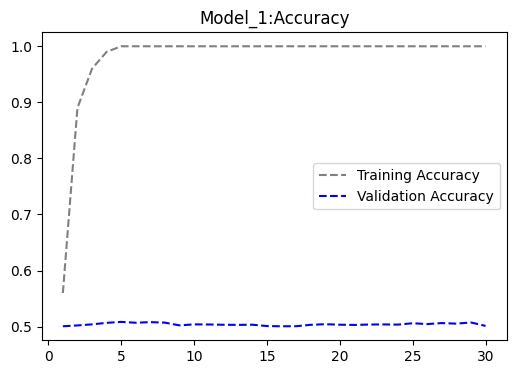

<Figure size 640x480 with 0 Axes>

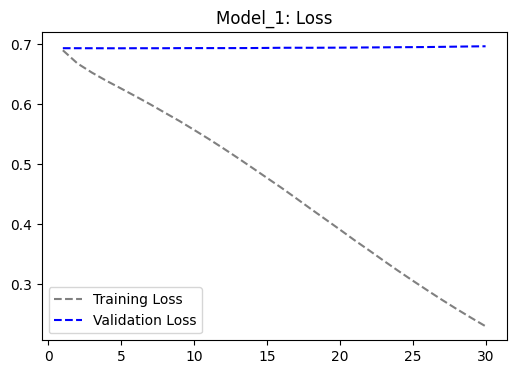

In [57]:
accuracy = Model_1.history['accuracy']
val_accuracy = Model_1.history['val_accuracy']

loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_1:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_1: Loss")
plt.legend()
plt.show()

In [58]:
test_model = load_model('model1.h5')
Model1_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

157/157 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5112
Loss: 0.693
Accuracy: 0.511


The model with 100 training samples which was built with just an embedding layer resulted in 51.7% Accuracy, which is not that bad because the model was just trained with 100 Samples.

### **Model 2: Increasing the training sample to 1000 and with Embedding Layer**

In [59]:
num_words = 10000
maxlen = 150

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=10000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

In [60]:
train_texts.shape

(10000, 150)

In [61]:
val_texts.shape

(10000, 150)

In [62]:
test_texts.shape

(5000, 150)

In [63]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_6 (Flatten)         (None, 1200)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model2.h5",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_2 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 18s 57ms/step - loss: 0.6756 - accuracy: 0.6157 - val_loss: 0.6307 - val_accuracy: 0.7221
Epoch 2/30
313/313 [==============================] - 6s 21ms/step - loss: 0.5129 - accuracy: 0.8111 - val_loss: 0.4458 - val_accuracy: 0.8216
Epoch 3/30
313/313 [==============================] - 4s 12ms/step - loss: 0.3517 - accuracy: 0.8707 - val_loss: 0.3622 - val_accuracy: 0.8498
Epoch 4/30
313/313 [==============================] - 2s 7ms/step - loss: 0.2739 - accuracy: 0.8968 - val_loss: 0.3338 - val_accuracy: 0.8591
Epoch 5/30
313/313 [==============================] - 3s 9ms/step - loss: 0.2254 - accuracy: 0.9199 - val_loss: 0.3223 - val_accuracy: 0.8626
Epoch 6/30
313/313 [==============================] - 2s 7ms/step - loss: 0.1899 - accuracy: 0.9344 - val_loss: 0.3145 - val_accuracy: 0.8665
Epoch 7/30
313/313 [==============================] - 2s 5ms/step - loss: 0.1594 - accuracy: 0.9475 - val_loss: 0.3172 - val_accuracy: 0.8645
Ep

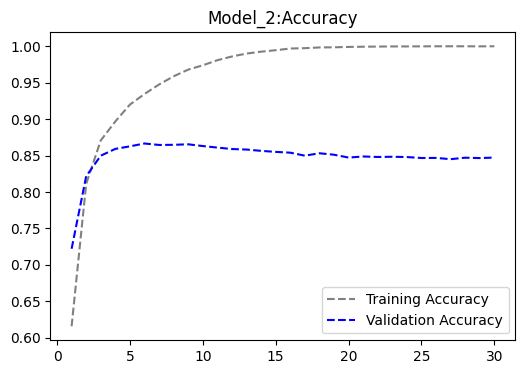

<Figure size 640x480 with 0 Axes>

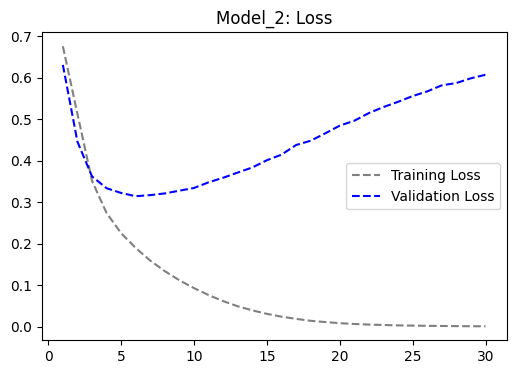

In [65]:
accuracy = Model_2.history['accuracy']
val_accuracy = Model_2.history['val_accuracy']

loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_2:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_2: Loss")
plt.legend()
plt.show()

In [66]:
test_model = load_model('model2.h5')
Model2_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model2_Results[0]:.3f}')
print(f'Accuracy: {Model2_Results[1]:.3f}')

157/157 [==============================] - 0s 2ms/step - loss: 0.2804 - accuracy: 0.8800
Loss: 0.280
Accuracy: 0.880


Model 3: Increase training size to 25000, everything else same

In [80]:
num_words = 10000
maxlen = 150

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=25000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

In [81]:
train_texts.shape

(25000, 150)

In [82]:
val_texts.shape

(10000, 150)

In [83]:
test_texts.shape

(5000, 150)

In [84]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_7 (Flatten)         (None, 1200)              0         
                                                                 
 dense_11 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model3.h5",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_3 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
782/782 [==============================] - 25s 31ms/step - loss: 0.5781 - accuracy: 0.7077 - val_loss: 0.3965 - val_accuracy: 0.8390
Epoch 2/30
782/782 [==============================] - 6s 8ms/step - loss: 0.3154 - accuracy: 0.8706 - val_loss: 0.2960 - val_accuracy: 0.8778
Epoch 3/30
782/782 [==============================] - 5s 7ms/step - loss: 0.2520 - accuracy: 0.8981 - val_loss: 0.2841 - val_accuracy: 0.8831
Epoch 4/30
782/782 [==============================] - 4s 5ms/step - loss: 0.2213 - accuracy: 0.9127 - val_loss: 0.2820 - val_accuracy: 0.8832
Epoch 5/30
782/782 [==============================] - 4s 5ms/step - loss: 0.1986 - accuracy: 0.9220 - val_loss: 0.2905 - val_accuracy: 0.8813
Epoch 6/30
782/782 [==============================] - 3s 4ms/step - loss: 0.1793 - accuracy: 0.9334 - val_loss: 0.2994 - val_accuracy: 0.8801
Epoch 7/30
782/782 [==============================] - 3s 4ms/step - loss: 0.1618 - accuracy: 0.9397 - val_loss: 0.3006 - val_accuracy: 0.8806
Epoc

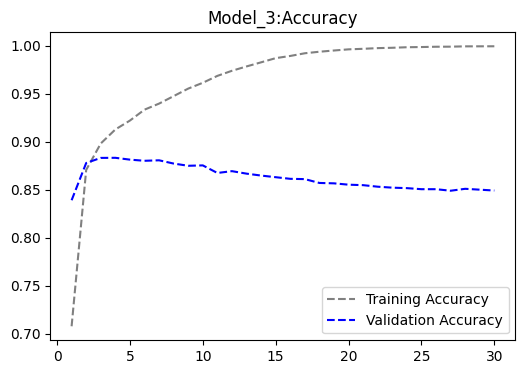

<Figure size 640x480 with 0 Axes>

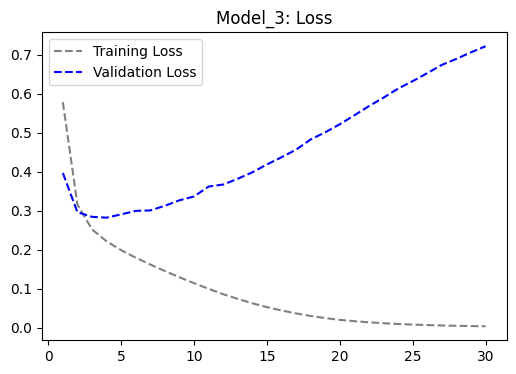

In [86]:
accuracy = Model_3.history['accuracy']
val_accuracy = Model_3.history['val_accuracy']

loss = Model_3.history["loss"]
val_loss = Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_3:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_3: Loss")
plt.legend()
plt.show()

In [87]:
test_model = load_model('model3.h5')
Model3_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model3_Results[0]:.3f}')
print(f'Accuracy: {Model3_Results[1]:.3f}')

157/157 [==============================] - 0s 2ms/step - loss: 0.2409 - accuracy: 0.8992
Loss: 0.241
Accuracy: 0.899


Model 4: Use same training size but use convolution 1D and Embadding layer together

In [88]:
model = Sequential()

maxlen = 150
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPooling1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 8)            80000     
                                                                 
 conv1d_6 (Conv1D)           (None, 148, 512)          12800     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 49, 512)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 47, 256)           393472    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 15, 256)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 13, 256)         

In [89]:
callbacks = ModelCheckpoint(
            filepath= "model4.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_4 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
782/782 [==============================] - 38s 46ms/step - loss: 0.6277 - accuracy: 0.6061 - val_loss: 0.5615 - val_accuracy: 0.7936
Epoch 2/30
782/782 [==============================] - 9s 12ms/step - loss: 0.3868 - accuracy: 0.8274 - val_loss: 0.4987 - val_accuracy: 0.8294
Epoch 3/30
782/782 [==============================] - 9s 11ms/step - loss: 0.3150 - accuracy: 0.8667 - val_loss: 0.4667 - val_accuracy: 0.8361
Epoch 4/30
782/782 [==============================] - 7s 9ms/step - loss: 0.2773 - accuracy: 0.8848 - val_loss: 0.4566 - val_accuracy: 0.8294
Epoch 5/30
782/782 [==============================] - 6s 8ms/step - loss: 0.2451 - accuracy: 0.9023 - val_loss: 0.4408 - val_accuracy: 0.8359
Epoch 6/30
782/782 [==============================] - 6s 8ms/step - loss: 0.2192 - accuracy: 0.9130 - val_loss: 0.4275 - val_accuracy: 0.8360
Epoch 7/30
782/782 [==============================] - 6s 8ms/step - loss: 0.1946 - accuracy: 0.9266 - val_loss: 0.4301 - val_accuracy: 0.8203
Ep

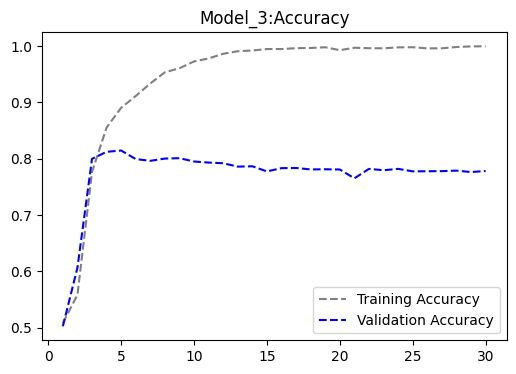

<Figure size 640x480 with 0 Axes>

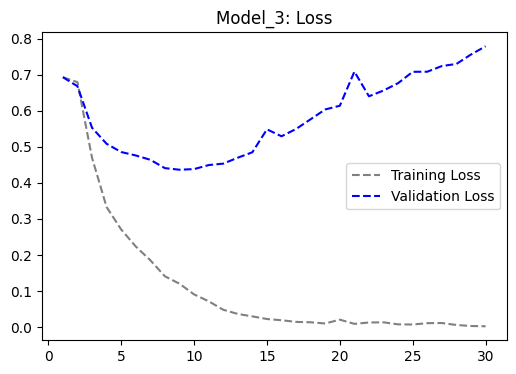

In [70]:
accuracy = Model_4.history['accuracy']
val_accuracy = Model_4.history['val_accuracy']

loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_4:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_4: Loss")
plt.legend()
plt.show()

In [72]:
test_model = load_model('model4.h5')
Model4_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model4_Results[0]:.3f}')
print(f'Accuracy: {Model4_Results[1]:.3f}')

157/157 [==============================] - 1s 4ms/step - loss: 0.3961 - accuracy: 0.8322
Loss: 0.396
Accuracy: 0.832


Model:5 A sequence model built on one-hot encoded vector sequences

In [92]:
import tensorflow as tf
max_length = 150
max_tokens = 10000
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               2568448   
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,568,513
Trainable params: 2,568,513
Non-trainable params: 0
___________________________________________________

In [93]:
callbacks = ModelCheckpoint(
            filepath= "model5.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_5 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
782/782 [==============================] - 41s 46ms/step - loss: 0.4766 - accuracy: 0.7762 - val_loss: 0.3490 - val_accuracy: 0.8594
Epoch 2/30
782/782 [==============================] - 34s 43ms/step - loss: 0.3126 - accuracy: 0.8786 - val_loss: 0.3668 - val_accuracy: 0.8661
Epoch 3/30
782/782 [==============================] - 34s 44ms/step - loss: 0.2626 - accuracy: 0.8981 - val_loss: 0.2794 - val_accuracy: 0.8830
Epoch 4/30
782/782 [==============================] - 35s 44ms/step - loss: 0.2293 - accuracy: 0.9153 - val_loss: 0.3033 - val_accuracy: 0.8723
Epoch 5/30
782/782 [==============================] - 34s 44ms/step - loss: 0.2096 - accuracy: 0.9247 - val_loss: 0.2981 - val_accuracy: 0.8740
Epoch 6/30
782/782 [==============================] - 34s 44ms/step - loss: 0.1863 - accuracy: 0.9313 - val_loss: 0.3968 - val_accuracy: 0.8197
Epoch 7/30
782/782 [==============================] - 34s 43ms/step - loss: 0.1584 - accuracy: 0.9438 - val_loss: 0.3202 - val_accuracy:

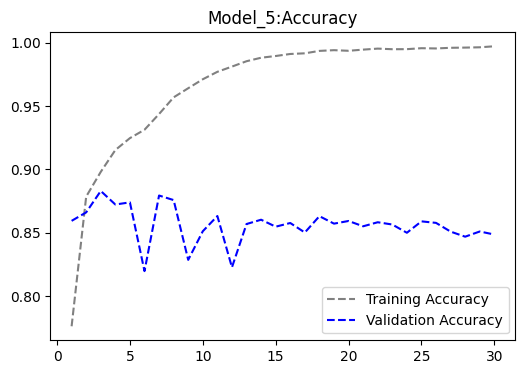

<Figure size 640x480 with 0 Axes>

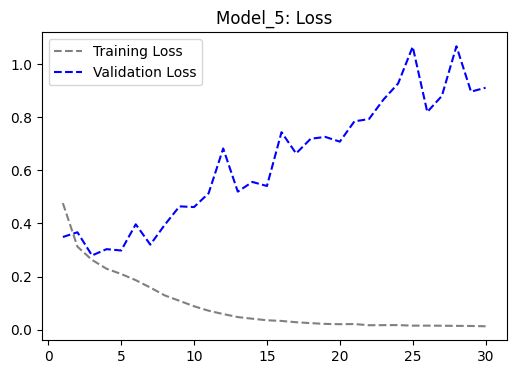

In [94]:
accuracy = Model_5.history['accuracy']
val_accuracy = Model_5.history['val_accuracy']

loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_5:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_5: Loss")
plt.legend()
plt.show()

In [95]:
test_model = load_model('model5.h5')
Model5_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model5_Results[0]:.3f}')
print(f'Accuracy: {Model5_Results[1]:.3f}')

157/157 [==============================] - 4s 20ms/step - loss: 0.2434 - accuracy: 0.9028
Loss: 0.243
Accuracy: 0.903


Model 6: LSTM

In [98]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_13 (Embedding)    (None, None, 256)         2560000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

In [99]:
callbacks = ModelCheckpoint(
            filepath= "model6.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_6 = model.fit(train_texts, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/10
782/782 [==============================] - 46s 54ms/step - loss: 0.4443 - accuracy: 0.7902 - val_loss: 0.3756 - val_accuracy: 0.8422
Epoch 2/10
782/782 [==============================] - 16s 20ms/step - loss: 0.2972 - accuracy: 0.8813 - val_loss: 0.3156 - val_accuracy: 0.8706
Epoch 3/10
782/782 [==============================] - 14s 18ms/step - loss: 0.2428 - accuracy: 0.9056 - val_loss: 0.2934 - val_accuracy: 0.8734
Epoch 4/10
782/782 [==============================] - 12s 16ms/step - loss: 0.2067 - accuracy: 0.9218 - val_loss: 0.3361 - val_accuracy: 0.8833
Epoch 5/10
782/782 [==============================] - 11s 15ms/step - loss: 0.1831 - accuracy: 0.9348 - val_loss: 0.3054 - val_accuracy: 0.8839
Epoch 6/10
782/782 [==============================] - 11s 14ms/step - loss: 0.1549 - accuracy: 0.9453 - val_loss: 0.3798 - val_accuracy: 0.8651
Epoch 7/10
782/782 [==============================] - 11s 14ms/step - loss: 0.1325 - accuracy: 0.9538 - val_loss: 0.3357 - val_accuracy:

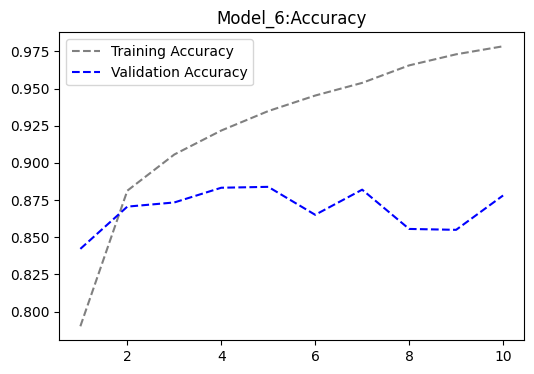

<Figure size 640x480 with 0 Axes>

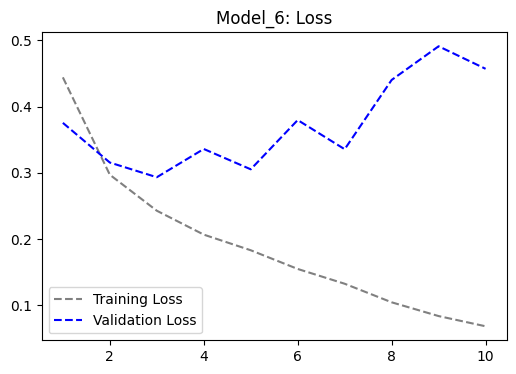

In [100]:
accuracy = Model_6.history['accuracy']
val_accuracy = Model_6.history['val_accuracy']

loss = Model_6.history["loss"]
val_loss = Model_6.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_6:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_6: Loss")
plt.legend()
plt.show()

In [101]:
test_model = load_model('model6.h5')
Model6_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model6_Results[0]:.3f}')
print(f'Accuracy: {Model6_Results[1]:.3f}')

157/157 [==============================] - 2s 6ms/step - loss: 0.2435 - accuracy: 0.9034
Loss: 0.243
Accuracy: 0.903


Model7 : Masking enable

In [102]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_14 (Embedding)    (None, None, 256)         2560000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

In [103]:
callbacks = ModelCheckpoint(
            filepath= "model7.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_7 = model.fit(train_texts, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/10
782/782 [==============================] - 386s 484ms/step - loss: 0.4359 - accuracy: 0.7909 - val_loss: 0.3468 - val_accuracy: 0.8491
Epoch 2/10
782/782 [==============================] - 355s 454ms/step - loss: 0.2816 - accuracy: 0.8854 - val_loss: 0.4036 - val_accuracy: 0.8258
Epoch 3/10
782/782 [==============================] - 362s 463ms/step - loss: 0.2362 - accuracy: 0.9089 - val_loss: 0.3977 - val_accuracy: 0.8443
Epoch 4/10
782/782 [==============================] - 352s 451ms/step - loss: 0.1974 - accuracy: 0.9247 - val_loss: 0.3580 - val_accuracy: 0.8795
Epoch 5/10
782/782 [==============================] - 347s 444ms/step - loss: 0.1652 - accuracy: 0.9400 - val_loss: 0.3189 - val_accuracy: 0.8822
Epoch 6/10
313/782 [===========>..................] - ETA: 3:15 - loss: 0.1197 - accuracy: 0.9593

KeyboardInterrupt: ignored

In [ ]:
accuracy = Model_7.history['accuracy']
val_accuracy = Model_7.history['val_accuracy']

loss = Model_7.history["loss"]
val_loss = Model_7.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_7:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_7: Loss")
plt.legend()
plt.show()

In [ ]:
test_model = load_model('model7.h5')
Model7_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model7_Results[0]:.3f}')
print(f'Accuracy: {Model7_Results[1]:.3f}')

Model 8: TRansformers

In [ ]:
vocab_size = 10000
embed_dim = 150
num_heads = 2
dense_dim = 32
maxlen = 150

inputs = keras.Input(shape=(maxlen,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = ModelCheckpoint(
            filepath= "model8.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_8 = model.fit(train_texts, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

In [ ]:
accuracy = Model_8.history['accuracy']
val_accuracy = Model_8.history['val_accuracy']

loss = Model_8.history["loss"]
val_loss = Model_8.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_8:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_8: Loss")
plt.legend()
plt.show()

In [ ]:
test_model = load_model('model8.h5')
Model8_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model8_Results[0]:.3f}')
print(f'Accuracy: {Model8_Results[1]:.3f}')

Model 9:Pretrained

In [105]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-11-27 01:32:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-27 01:32:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-27 01:32:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [106]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [109]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

NameError: ignored

In [108]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

NameError: ignored

In [107]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

NameError: ignored

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")